In [1]:
%matplotlib inline


Variational Sparse GP for Binary Classification
===============================================

Here we fit the hyperparameters of a Gaussian Process by maximizing the (log)
marginal likelihood. This is commonly referred to as empirical Bayes, or
type-II maximum likelihood estimation.



In [2]:
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tensorflow.keras.layers import Layer, InputLayer
from tensorflow.keras.initializers import Identity, Constant

from gpdre.initializers import KMeans, RandomSubset
from gpdre.datasets import make_classification_dataset
from gpdre.plotting import fill_between_stddev
from gpdre.utils import get_kl_weight, DistributionPair

from collections import defaultdict
from tqdm import trange

In [3]:
# shortcuts
tfd = tfp.distributions
kernels = tfp.math.psd_kernels


# constants
num_train = 500  # nbr training points in synthetic dataset
num_test = 500
num_features = 2  # dimensionality
num_index_points = 256  # nbr of index points
num_samples = 25
quadrature_size = 20

num_inducing_points = 50
num_epochs = 1000
batch_size = 64
shuffle_buffer_size = 500

jitter = 1e-6

kernel_cls = kernels.ExponentiatedQuadratic

seed = 8888  # set random seed for reproducibility
random_state = np.random.RandomState(seed)

x_min, x_max = 0.0, 1.0
y_min, y_max = -6.0, 4.0

# index points
X_q = np.linspace(x_min, x_max, num_index_points).reshape(-1, num_features)

golden_ratio = 0.5 * (1 + np.sqrt(5))

In [4]:
def golden_size(width):
    return (width, width / golden_ratio)

In [5]:
rc = {
    "figure.figsize": golden_size(10),
    "font.serif": ['Times New Roman'],
    "text.usetex": True,
}

In [6]:
sns.set(context="notebook",
        style="ticks",
        palette="colorblind",
        font="serif",
        rc=rc)

In [7]:
train = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=[0.5, 0.5]),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=[[-2.0, 3.0], [2.0, 3.0]], scale_diag=[1.0, 2.0])
)
test = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=[0.5, 0.5]),
    components_distribution=tfd.MultivariateNormalDiag(
        loc=[[0.0, -1.0], [4.0, -1.0]])
)
pair = DistributionPair(test, train)

In [8]:
x2, x1 = np.mgrid[-4:9:50j,-6:8:50j]
X_q = np.dstack([x1, x2])

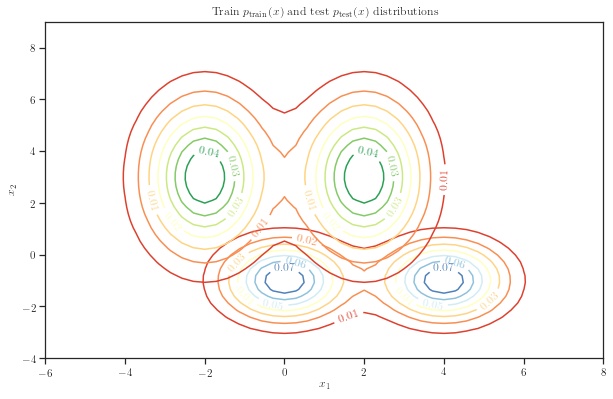

In [9]:
fig, ax = plt.subplots()

ax.set_title(r"Train $p_{\mathrm{train}}(x)$ and test $p_{\mathrm{test}}(x)$ distributions")

contours_train = ax.contour(x1, x2, pair.p.prob(X_q), cmap="RdYlBu")
contours_test = ax.contour(x1, x2, pair.q.prob(X_q), cmap="RdYlGn")

ax.clabel(contours_train, fmt='%.2f')
ax.clabel(contours_test, fmt='%.2f')

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

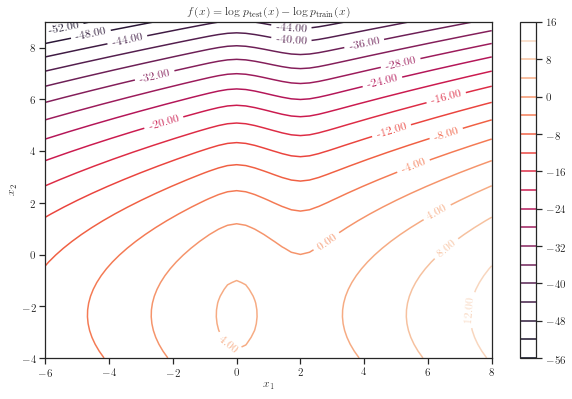

In [10]:
fig, ax = plt.subplots()

ax.set_title(r"$f(x) = \log p_{\mathrm{test}}(x) - \log p_{\mathrm{train}}(x)$")

contours = ax.contour(x1, x2, pair.logit(X_q), levels=20)

fig.colorbar(contours, ax=ax)
ax.clabel(contours, fmt='%.2f')

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

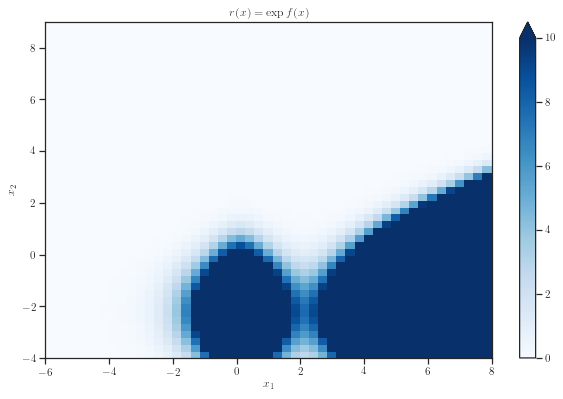

In [11]:
fig, ax = plt.subplots()

ax.set_title(r"$r(x) = \exp f(x)$")

contours = ax.pcolor(x1, x2, pair.density_ratio(X_q), vmax=1e+1, cmap="Blues")

fig.colorbar(contours, extend="max", ax=ax)

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

In [12]:
X_test, X_train = pair.make_dataset(num_train + num_test, seed=seed)
X_train = X_train.squeeze()
X_test = X_test.squeeze()

In [13]:
X, y = make_classification_dataset(X_test, X_train)

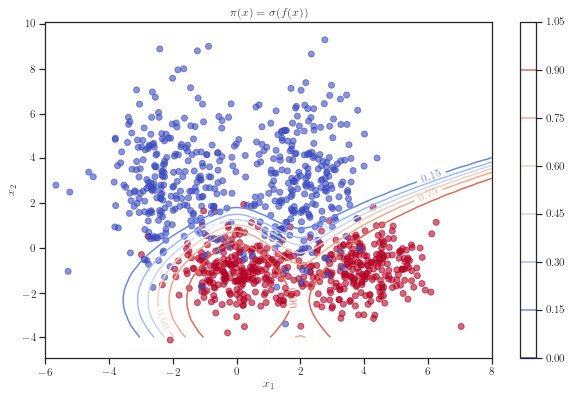

In [14]:
fig, ax = plt.subplots()

ax.set_title(r"$\pi(x) = \sigma(f(x))$")

contours = ax.contour(x1, x2, pair.optimal_score(X_q), cmap="coolwarm")

fig.colorbar(contours, ax=ax)
ax.clabel(contours, fmt='%.2f')

# ax.scatter(*X_train.T, c="tab:blue", alpha=0.7, label="train")
# ax.scatter(*X_test.T, c="tab:red", marker='x', alpha=0.7, label="test")

ax.scatter(*X.T, c=y, alpha=0.6, cmap="coolwarm")
# ax.set_yticks([0, 1])
# ax.set_yticklabels([r"$x_q \sim q(x)$", r"$x_p \sim p(x)$"])
# ax.set_xlabel('$x$')

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

# ax.legend()

plt.show()

In [15]:
class GaussianProcessClassifier:

    def __init__(self, input_dim, num_inducing_points,
                 inducing_index_points_initializer, use_ard=True,
                 jitter=1e-6, dtype=tf.float64, seed=None):

        # TODO: should support an optional kernel argument, and only
        # instantiate a new kernel if this argument is not provided.
        # TODO: Add options for initial values of each parameter.
        # TODO: Add option for different bijectors, particular SoftPlus.
        self.amplitude = tfp.util.TransformedVariable(
            initial_value=1.0, bijector=tfp.bijectors.Exp(),
            dtype=dtype, name="amplitude")
        self.length_scale = tfp.util.TransformedVariable(
            initial_value=1.0, bijector=tfp.bijectors.Exp(),
            dtype=dtype, name="length_scale")
        self.scale_diag = tfp.util.TransformedVariable(
            initial_value=np.ones(input_dim), bijector=tfp.bijectors.Exp(),
            dtype=dtype, name="scale_diag")

        self.base_kernel = kernel_cls(amplitude=self.amplitude,
                                      length_scale=self.length_scale)

        if input_dim > 1 and use_ard:
            self.kernel = kernels.FeatureScaled(self.base_kernel,
                                                scale_diag=self.scale_diag)
        else:
            self.kernel = self.base_kernel

        self.observation_noise_variance = tfp.util.TransformedVariable(
            initial_value=1e-3, bijector=tfp.bijectors.Exp(),
            dtype=dtype, name="observation_noise_variance")

        self.inducing_index_points = tf.Variable(
            inducing_index_points_initializer(
                shape=(num_inducing_points, input_dim), dtype=dtype),
            name="inducing_index_points")

        self.variational_inducing_observations_loc = tf.Variable(
            np.zeros(num_inducing_points),
            name="variational_inducing_observations_loc")

        self.variational_inducing_observations_scale = tf.Variable(
            np.eye(num_inducing_points),
            name="variational_inducing_observations_scale"
        )

        self.jitter = jitter
        self.seed = seed

    def __call__(self, X, jitter=None):

        if jitter is None:
            jitter = self.jitter

        return tfd.VariationalGaussianProcess(
            kernel=self.kernel, index_points=X,
            inducing_index_points=self.inducing_index_points,
            variational_inducing_observations_loc=self.variational_inducing_observations_loc,
            variational_inducing_observations_scale=self.variational_inducing_observations_scale,
            observation_noise_variance=self.observation_noise_variance,
            jitter=jitter
        )

    def compile(self, optimizer=None):

        # TODO: support specification by strings

        if optimizer is None:
            optimizer = tf.keras.optimizers.Adam()

        self.optimizer = optimizer

    def fit(self, X, y, num_epochs, batch_size=64, quadrature_size=20, buffer_size=256):

        num_train = len(X)
        kl_weight = get_kl_weight(num_train, batch_size)

        @tf.function
        def elbo(y_batch, qf_batch):

            ell = qf_batch.surrogate_posterior_expected_log_likelihood(
                observations=y_batch,
                log_likelihood_fn=GaussianProcessClassifier.log_likelihood,
                quadrature_size=quadrature_size)
            kl = qf_batch.surrogate_posterior_kl_divergence_prior()

            return ell - kl_weight * kl

        @tf.function
        def train_step(X_batch, y_batch):
            
            qf_batch = self(X_batch)

            with tf.GradientTape() as tape:
                nelbo = - elbo(y_batch, qf_batch)
                gradients = tape.gradient(nelbo, qf_batch.trainable_variables)
                self.optimizer.apply_gradients(zip(gradients, qf_batch.trainable_variables))

            return nelbo

        dataset = tf.data.Dataset.from_tensor_slices((X, y)) \
                                 .shuffle(seed=self.seed, buffer_size=buffer_size) \
                                 .batch(batch_size, drop_remainder=True)

        for epoch in trange(num_epochs):

            for step, (X_batch, y_batch) in enumerate(dataset):

                train_step(X_batch, y_batch)

    @staticmethod
    def make_likelihood(f):

        return tfd.Independent(tfd.Bernoulli(logits=f),
                               reinterpreted_batch_ndims=1)

    @staticmethod
    def log_likelihood(y, f):

        likelihood = GaussianProcessClassifier.make_likelihood(f)
        return likelihood.log_prob(y)

    def sample_predictive(self, X, sample_shape=(), jitter=None):

        f = self(X, jitter).sample(sample_shape)
        return self.make_likelihood(f)

In [16]:
class GaussianProcessDensityRatioEstimator(GaussianProcessClassifier):

    def fit(self, X_top, X_bot, num_epochs, batch_size=64, quadrature_size=20, buffer_size=256):

        X, y = make_classification_dataset(X_top, X_bot)

        super(GaussianProcessDensityRatioEstimator, self).fit(X, y, 
                                                              num_epochs=num_epochs, 
                                                              batch_size=batch_size,
                                                              quadrature_size=quadrature_size,
                                                              buffer_size=buffer_size)

    def something(self, X, jitter=None):

        if jitter is None:
            jitter = self.jitter

        qf = self(X)
        qr = tfd.LogNormal(loc=qf.mean(), scale=qf.stddev())

        return tfd.Independent(qr, reinterpreted_batch_ndims=1)

In [17]:
gpdre = GaussianProcessDensityRatioEstimator(
    input_dim=num_features, 
    num_inducing_points=num_inducing_points,
    inducing_index_points_initializer=KMeans(X)
)
gpdre.compile()

In [18]:
gpdre.fit(X_test, X_train, num_epochs=num_epochs)

  0%|          | 0/1000 [00:00<?, ?it/s]

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


100%|██████████| 1000/1000 [01:20<00:00, 12.41it/s]


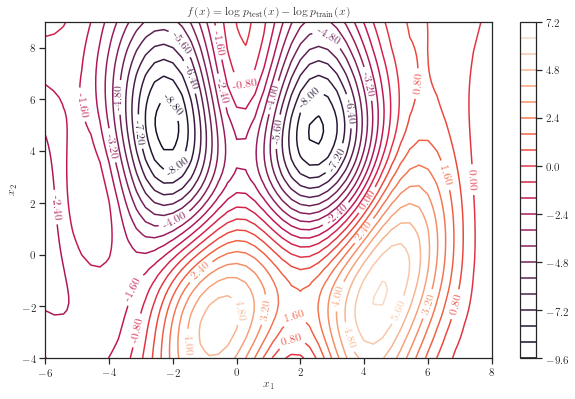

In [19]:
fig, ax = plt.subplots()

ax.set_title(r"$f(x) = \log p_{\mathrm{test}}(x) - \log p_{\mathrm{train}}(x)$")

contours = ax.contour(x1, x2, gpdre(X_q).mean(), levels=20)

fig.colorbar(contours, ax=ax)
ax.clabel(contours, fmt='%.2f')

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

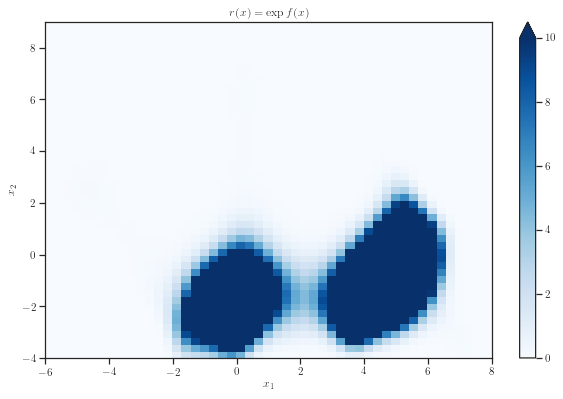

In [20]:
fig, ax = plt.subplots()

ax.set_title(r"$r(x) = \exp f(x)$")

contours = ax.pcolor(x1, x2, gpdre.something(X_q).mode(), vmax=1e+1, cmap="Blues")

fig.colorbar(contours, extend="max", ax=ax)

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

plt.show()

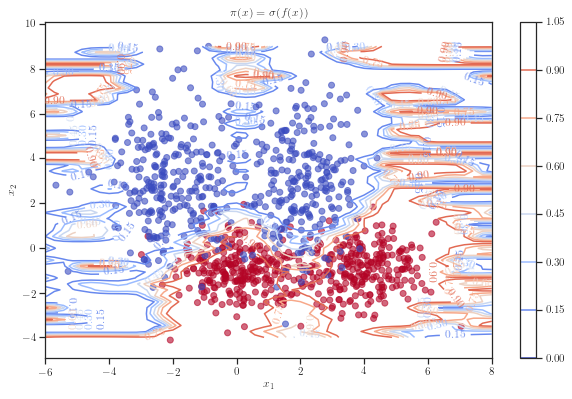

In [21]:
fig, ax = plt.subplots()

ax.set_title(r"$\pi(x) = \sigma(f(x))$")

contours = ax.contour(x1, x2, gpdre.sample_predictive(X_q).mean(), cmap="coolwarm")

fig.colorbar(contours, ax=ax)
ax.clabel(contours, fmt='%.2f')

# ax.scatter(*X_train.T, c="tab:blue", alpha=0.7, label="train")
# ax.scatter(*X_test.T, c="tab:red", marker='x', alpha=0.7, label="test")

ax.scatter(*X.T, c=y, alpha=0.6, cmap="coolwarm")
# ax.set_yticks([0, 1])
# ax.set_yticklabels([r"$x_q \sim q(x)$", r"$x_p \sim p(x)$"])
# ax.set_xlabel('$x$')

ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

# ax.legend()

plt.show()